In [1]:
import numpy as np 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from keras import losses
from keras import metrics
from keras import optimizers
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from data_utils import *
from pypower.api import case9, ppoption, runpf, printpf
import matplotlib.pyplot as plt
import copy
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
X = []
y = []
grids = []
for i in range(1, 10001):
    g = Grid("../data/result_%d.mat" % i)
    grids.append(g)
    # Input parameters
    pd = g.get_pd() #/ g.baseMVA 
    qd = g.get_qd() #/ g.baseMVA 
    X.append(np.append(pd, qd))
    # Output parameters
    pg = g.get_pg()
    v  = g.get_pv_voltage()
    y.append(np.append(pg,v))
grids = np.array(grids)
X = np.array(X)
y = np.array(y)
train_indices = np.random.choice(range(10000), 8000)
test_indices = [i for i in range(10000) if not i in train_indices]
Xtr, ytr = X[train_indices, :], y[train_indices,:]
Xts, yts = X[test_indices, :], y[test_indices,:]
print("X_train:", Xtr.shape)
print("y_train:", ytr.shape)
print("X_test:", Xts.shape)
print("y_test:", yts.shape)

X_train: (8000, 18)
y_train: (8000, 6)
X_test: (4464, 18)
y_test: (4464, 6)


In [3]:
model = Sequential()
model.add(Dense(units=50, input_dim=18))
model.add(Dense(units=6, input_dim=50))
model.compile(loss='mean_squared_error',
              optimizer=optimizers.Adam(lr=0.01),
              metrics=[metrics.mean_squared_error])

In [4]:
model_hist = model.fit(Xtr, ytr, validation_data=(Xts,yts), epochs=30, batch_size=100, verbose=2)

Train on 8000 samples, validate on 4464 samples
Epoch 1/30
 - 0s - loss: 320.8621 - mean_squared_error: 320.8621 - val_loss: 2.6582 - val_mean_squared_error: 2.6582
Epoch 2/30
 - 0s - loss: 2.2470 - mean_squared_error: 2.2470 - val_loss: 2.0907 - val_mean_squared_error: 2.0907
Epoch 3/30
 - 0s - loss: 2.0637 - mean_squared_error: 2.0637 - val_loss: 1.9911 - val_mean_squared_error: 1.9911
Epoch 4/30
 - 0s - loss: 1.9661 - mean_squared_error: 1.9661 - val_loss: 1.8882 - val_mean_squared_error: 1.8882
Epoch 5/30
 - 0s - loss: 1.8460 - mean_squared_error: 1.8460 - val_loss: 1.7719 - val_mean_squared_error: 1.7719
Epoch 6/30
 - 0s - loss: 1.7699 - mean_squared_error: 1.7699 - val_loss: 1.5632 - val_mean_squared_error: 1.5632
Epoch 7/30
 - 0s - loss: 1.5540 - mean_squared_error: 1.5540 - val_loss: 1.4019 - val_mean_squared_error: 1.4019
Epoch 8/30
 - 0s - loss: 1.3756 - mean_squared_error: 1.3756 - val_loss: 1.4427 - val_mean_squared_error: 1.4427
Epoch 9/30
 - 0s - loss: 1.2144 - mean_squar

In [5]:
preds = model.predict(Xts)

In [23]:
test_grids = copy.deepcopy(grids[test_indices])
test_costs = [g.get_cost() for g in test_grids]
pred_costs = []
legal = []
ppopt = ppoption(PF_ALG=2, VERBOSE=0, OUT_ALL = 0)
for i, pred in enumerate(preds):
    pred_pg = y[i, :3]
    pred_vm = y[i, 3:]
    test_grids[i].set_powers(pred_pg)
    test_grids[i].set_voltage(pred_vm)
    ppc = test_grids[i].to_dict()
    results, succeed = runpf(ppc, ppopt)
    test_grids[i].set_powers(results['gen'][:,PG])
    legal.append(succeed)
    pred_costs.append(test_grids[i].get_cost())

In [24]:
print("Success Rate:", np.mean(legal))
cost_dist = np.array(pred_costs) / np.array(test_costs) - 1.0

Success Rate: 1.0


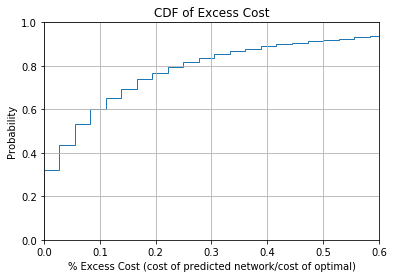

In [92]:
fig, ax = plt.subplots()
n, bins, patches = plt.hist(cost_dist, bins=200, normed = 1, cumulative=True, facecolor='g', histtype='step')
plt.xlabel('% Excess Cost (cost of predicted network/cost of optimal)')
plt.ylabel('Probability')
#ax.minorticks_on()
#ax.xaxis.grid(True, which='minor')
plt.title('CDF of Excess Cost')
plt.axis([0.0, 0.6, 0.0, 1])
plt.grid(True)
plt.show()

In [93]:
print("Mean: %f" % np.mean(cost_dist))
print("Median: %f" % np.median(cost_dist))
print("Stdev: %f" % np.std(cost_dist))
deciles = np.arange(0, 100, 5)
decile_vals = np.percentile(cost_dist, deciles)
print("Decile\tCost")
print("------\t----")
for i in range(20):
    print("%d\t|%f" % (deciles[i], decile_vals[i]))

Mean: 0.178979
Median: 0.072202
Stdev: 0.324558
Decile	Cost
------	----
0	|-0.000720
5	|0.001244
10	|0.003213
15	|0.006083
20	|0.010646
25	|0.016470
30	|0.023810
35	|0.033235
40	|0.044091
45	|0.057662
50	|0.072202
55	|0.089555
60	|0.109775
65	|0.137090
70	|0.168639
75	|0.202062
80	|0.254290
85	|0.326574
90	|0.450304
95	|0.707808
